In [1]:
import numpy as np
import numba
from numba import cuda
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import pandas as pd
#%matplotlib widget*
figsize=(8,4)

import rumdpy as rumd
import rumdpy as rp

In [2]:
print(numba.__version__)

0.55.1


In [3]:

def benchmark(nx, ny, nz, pb, tp, skin, 
              gridsync=True, UtilizeNIII=True, PairForceMethod='NsqNbList', steps=1000, cut=2.5, 
             integrator='NVE'):

    # Generate numpy arrays for particle positions and simbox of a FCC lattice with a given density 
    positions, simbox_data = rp.generate_fcc_positions(nx=nx, ny=ny, nz=nz, rho=0.8442)
    N, D = positions.shape
    assert N==nx*ny*nz*4, f'Wrong number particles (FCC), {N} <> {nx*ny*nz*4}'
    assert D==3, f'Wrong dimension (FCC), {D} <> {3}'

    ### Make configuration. Could be read from file or generated from single convenience function, but this shows flexibility
    c1 = rp.Configuration(N, D, simbox_data)
    c1['r'] = positions
    c1['v'] = rp.generate_random_velocities(N, D, T=1.44)
    c1['m'] =  np.ones(N, dtype=np.float32)     # Set masses
    c1.ptype = np.zeros(N, dtype=np.int32)      # Set types
   
    # Make the pair potential. NOTE: params is a 2 dimensional numpy array of tuples
    params = np.zeros((1,1), dtype="f,f,f")
    params[0][0] = (4., -4., 2.5)
    print('Pairpotential paramaters:\n', params)
    LJ = rp.PairPotential(c1, rp.apply_shifted_force_cutoff(rp.LJ_12_6), UtilizeNIII=UtilizeNIII, params=params, max_num_nbs=1000)
    num_cscalars = 3
 
    
    # NOTE: following three objects are specific to system size and other parameters for technical reasons

    interactions = rp.make_interactions(c1, pb=pb, tp=tp, pair_potential = LJ, num_cscalars=num_cscalars, 
                                        verbose=True, gridsync=gridsync, UtilizeNIII=UtilizeNIII,)

    step_nve = rumd.make_step_nve(c1, pb=pb, tp=tp, verbose=True, gridsync=gridsync)
    step_nvt = rumd.make_step_nvt(c1, pb=pb, tp=tp, verbose=True, gridsync=gridsync)
    
    integrate_nve = rumd.make_integrator(c1, step_nve, interactions, pb=pb, tp=tp,
                                        verbose=True, gridsync=gridsync ) 
    integrate_nvt = rumd.make_integrator(c1, step_nvt, interactions, pb=pb, tp=tp,
                                        verbose=True, gridsync=gridsync )
   
    dt = np.float32(0.005)
    skin = np.float32(0.5)
    md_time_unit = 2.e-12
    print(f'dt = {dt} = {dt*md_time_unit*1e15} fs')

    c1.copy_to_device()           
    LJ.copy_to_device()
 
    interaction_params = (LJ.d_params, skin, LJ.nblist.d_nblist,  LJ.nblist.d_nbflag)
    integrator_params = (dt, )

    start = cuda.event()
    end = cuda.event()

 
    MATS = 50
    TPS = MATS*1.e6/N
       
    inner_steps = 1000
    test_steps = int(TPS*1)
    print('test_steps : ', test_steps)
    
    
    tps_max = 0.0
    skins = np.linspace(0.1, 1.4, 14)
    timings = np.zeros_like(skins)
    nblist_updates = np.zeros_like(skins)
    
    T = np.float32(0.7)
    tau=0.2
    omega2 = np.float32(4.0*np.pi*np.pi/tau/tau)
    degrees = N*D - D
    
    for i in range(len(skins)):
        c1.copy_to_device()
        LJ.copy_to_device()

        thermostat_state = np.zeros(2, dtype=np.float32)
        d_thermostat_state = cuda.to_device(thermostat_state)
        
        interaction_params = (LJ.d_params, np.float32(skins[i]), LJ.nblist.d_nblist, LJ.nblist.d_nbflag)
        nve_params = (dt, )
        nvt_params = (dt, T, omega2, degrees,  d_thermostat_state)
        start.record()
        if integrator=='NVE':
            integrate_nve(c1.d_vectors, c1.d_scalars, c1.d_ptype, c1.d_r_im, c1.simbox.d_data, interaction_params,
                        nve_params, test_steps)
        if integrator=='NVT':         
            integrate_nvt(c1.d_vectors, c1.d_scalars, c1.d_ptype, c1.d_r_im, c1.simbox.d_data, interaction_params,
                        nvt_params, test_steps)
        nbflag = LJ.nblist.d_nbflag.copy_to_host()
        end.record()
        end.synchronize()
        
        timings[i] = cuda.event_elapsed_time(start, end)
        tps = test_steps/timings[i]*1000    

        print(f'{i}, {skins[i]:.3f}, {tps:.3f}, nbflag:{nbflag}')
        if tps>tps_max:
            tps_max = tps
            skin = skins[i]
        nblist_updates[i] = nbflag[2]
        
    print('optimal skin:', skin)
    
    c1.copy_to_device()                
    LJ.copy_to_device()
    
    interaction_params = (LJ.d_params, np.float32(skins[i]), LJ.nblist.d_nblist, LJ.nblist.d_nbflag)

    start.record()
  
    scalars_t = []
    tt = []
    for i in range(steps):
        if integrator=='NVE':
            integrate_nve(c1.d_vectors, c1.d_scalars, c1.d_ptype, c1.d_r_im, c1.simbox.d_data, interaction_params,
                        nve_params, inner_steps)
        if integrator=='NVT':         
            integrate_nvt(c1.d_vectors, c1.d_scalars, c1.d_ptype, c1.d_r_im, c1.simbox.d_data, interaction_params,
                        nvt_params, inner_steps)
        scalars_t.append(np.sum(c1.d_scalars.copy_to_host(), axis=0))
        tt.append(i*inner_steps*dt)
            
    end.record()
    end.synchronize()
    timing_numba = cuda.event_elapsed_time(start, end)
    nbflag = LJ.nblist.d_nbflag.copy_to_host()    
    tps = steps*inner_steps/timing_numba*1000
    ns_per_step = dt*md_time_unit*1e9

    print('\tsteps :', steps*inner_steps)
    print('\tnbflag : ', nbflag)
    print('\ttime :', timing_numba/1000, 's')
    print('\ttime/steps :', timing_numba/(steps*inner_steps)*1000, 'us')
    print('\tTPS : ', tps )
    print('\tMATS : ', steps*inner_steps*N/timing_numba*1000/1e6)
    print('\tns/day : ', tps*ns_per_step*3600*24 )
    print('\tms/year : ', tps*ns_per_step*3600*24*1e-6*365)
    print()
   
    df = pd.DataFrame(np.array(scalars_t), columns=c1.sid.keys())
    if UtilizeNIII:
        df['u'] *= 2
        df['w'] *= 2
        df['lap'] *= 2
    df['w'] *= 1/D/2
    df['t'] = np.array(tt)  
    
    rumd.plot_scalars(df, N, D, figsize=(15,4))
    
    return  skins, timings, nblist_updates

# N=256

Pairpotential paramaters:
 [[(4., -4., 2.5)]]
Generating interactions for 256 particles in 3 dimensions:
	pb: 8, tp:32, num_blocks:32
	Number (virtual) particles: 256
	Number of threads 8192
Generating NVE integrator for 256 particles in 3 dimensions:
	pb: 8, tp:32, num_blocks:32
	Number (virtual) particles: 256
	Number of threads 8192
Generating NVT integrator for 256 particles in 3 dimensions:
	pb: 8, tp:32, num_blocks:32
	Number (virtual) particles: 256
	Number of threads 8192
dt = 0.004999999888241291 = 9.999999776482582 fs
test_steps :  195312


/home/tbs/anaconda3/lib/python3.9/site-packages/numba/cuda/compiler.py:726: NumbaPerformanceWarning: Grid size (32) < 2 * SM count (80) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


0, 0.100, 62603.410, nbflag:[    0     0 52761]
1, 0.200, 105470.499, nbflag:[    0     0 28341]
2, 0.300, 110663.791, nbflag:[    0     0 19111]
3, 0.400, 103551.610, nbflag:[    0     0 14216]
4, 0.500, 99894.561, nbflag:[    0     0 11142]
5, 0.600, 101721.643, nbflag:[   0    0 9071]
6, 0.700, 95724.159, nbflag:[   0    0 7524]
7, 0.800, 99435.615, nbflag:[   0    0 6350]
8, 0.900, 91029.959, nbflag:[   0    0 5409]
9, 1.000, 96970.612, nbflag:[   0    0 4623]
10, 1.100, 93482.386, nbflag:[   0    0 3976]
11, 1.200, 92928.900, nbflag:[   0    0 3420]
12, 1.300, 83947.502, nbflag:[   0    0 2962]
13, 1.400, 81644.208, nbflag:[   0    0 2590]
optimal skin: 0.3
	steps : 1000000
	nbflag :  [    0     0 13258]
	time : 13.1390654296875 s
	time/steps : 13.139065429687498 us
	TPS :  76108.91393694689
	MATS :  19.483881967858405
	ns/day :  65758.100171714
	ms/year :  24.00170656267561



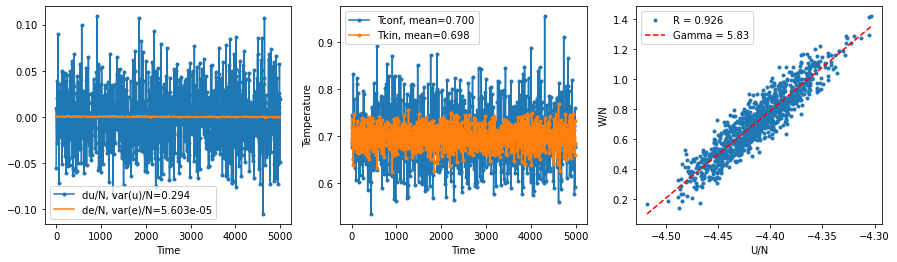

In [4]:
skins, timings, nblist_updates = benchmark(nx=4, ny=4, nz=4, pb=8, tp=32, skin=0.4, UtilizeNIII=False)

Pairpotential paramaters:
 [[(4., -4., 2.5)]]
Generating interactions for 256 particles in 3 dimensions:
	pb: 8, tp:32, num_blocks:32
	Number (virtual) particles: 256
	Number of threads 8192
Generating NVE integrator for 256 particles in 3 dimensions:
	pb: 8, tp:32, num_blocks:32
	Number (virtual) particles: 256
	Number of threads 8192
Generating NVT integrator for 256 particles in 3 dimensions:
	pb: 8, tp:32, num_blocks:32
	Number (virtual) particles: 256
	Number of threads 8192
dt = 0.004999999888241291 = 9.999999776482582 fs
test_steps :  195312


/home/tbs/anaconda3/lib/python3.9/site-packages/numba/cuda/compiler.py:726: NumbaPerformanceWarning: Grid size (32) < 2 * SM count (80) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


0, 0.100, 58120.767, nbflag:[    0     0 52621]
1, 0.200, 96140.023, nbflag:[    0     0 28369]
2, 0.300, 98788.163, nbflag:[    0     0 19106]
3, 0.400, 91291.432, nbflag:[    0     0 14204]
4, 0.500, 93523.783, nbflag:[    0     0 11159]
5, 0.600, 93716.202, nbflag:[   0    0 9095]
6, 0.700, 91667.007, nbflag:[   0    0 7535]
7, 0.800, 87032.197, nbflag:[   0    0 6340]
8, 0.900, 89138.050, nbflag:[   0    0 5414]
9, 1.000, 84099.096, nbflag:[   0    0 4611]
10, 1.100, 78995.767, nbflag:[   0    0 3977]
11, 1.200, 84330.877, nbflag:[   0    0 3416]
12, 1.300, 81714.200, nbflag:[   0    0 2963]
13, 1.400, 72667.077, nbflag:[   0    0 2577]
optimal skin: 0.3
	steps : 1000000
	nbflag :  [    0     0 13245]
	time : 14.482740234375 s
	time/steps : 14.482740234375 us
	TPS :  69047.70670584045
	MATS :  17.676212916695157
	ns/day :  59657.217260403406
	ms/year :  21.774884300047244



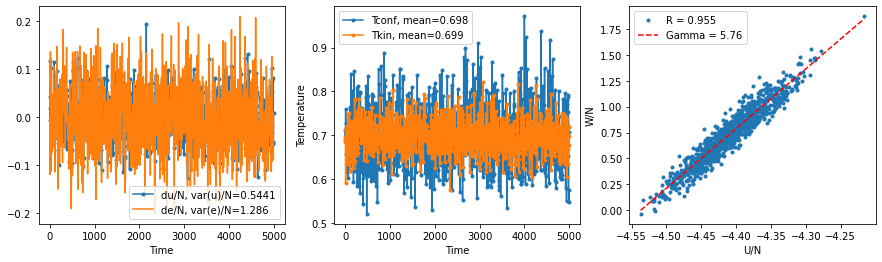

In [5]:
skins, timings, nblist_updates = benchmark(nx=4, ny=4, nz=4, pb=8, tp=32, skin=0.4, UtilizeNIII=False, integrator='NVT')

# N=512

Pairpotential paramaters:
 [[(4., -4., 2.5)]]
Generating interactions for 512 particles in 3 dimensions:
	pb: 8, tp:32, num_blocks:64
	Number (virtual) particles: 512
	Number of threads 16384
Generating NVE integrator for 512 particles in 3 dimensions:
	pb: 8, tp:32, num_blocks:64
	Number (virtual) particles: 512
	Number of threads 16384
Generating NVT integrator for 512 particles in 3 dimensions:
	pb: 8, tp:32, num_blocks:64
	Number (virtual) particles: 512
	Number of threads 16384
dt = 0.004999999888241291 = 9.999999776482582 fs
test_steps :  97656


/home/tbs/anaconda3/lib/python3.9/site-packages/numba/cuda/compiler.py:726: NumbaPerformanceWarning: Grid size (64) < 2 * SM count (80) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


0, 0.100, 40135.656, nbflag:[    0     0 27845]
1, 0.200, 77391.223, nbflag:[    0     0 14852]
2, 0.300, 77539.160, nbflag:[    0     0 10067]
3, 0.400, 80602.216, nbflag:[   0    0 7506]
4, 0.500, 78708.945, nbflag:[   0    0 5907]
5, 0.600, 76420.941, nbflag:[   0    0 4826]
6, 0.700, 77464.326, nbflag:[   0    0 4008]
7, 0.800, 74441.176, nbflag:[   0    0 3402]
8, 0.900, 73231.525, nbflag:[   0    0 2913]
9, 1.000, 71328.147, nbflag:[   0    0 2519]
10, 1.100, 68905.808, nbflag:[   0    0 2189]
11, 1.200, 69655.288, nbflag:[   0    0 1900]
12, 1.300, 64813.038, nbflag:[   0    0 1665]
13, 1.400, 64592.595, nbflag:[   0    0 1464]
optimal skin: 0.4
	steps : 1000000
	nbflag :  [    0     0 14967]
	time : 15.5820048828125 s
	time/steps : 15.5820048828125 us
	TPS :  64176.59393131338
	MATS :  32.85841609283245
	ns/day :  55448.57591728248
	ms/year :  20.238730209808104



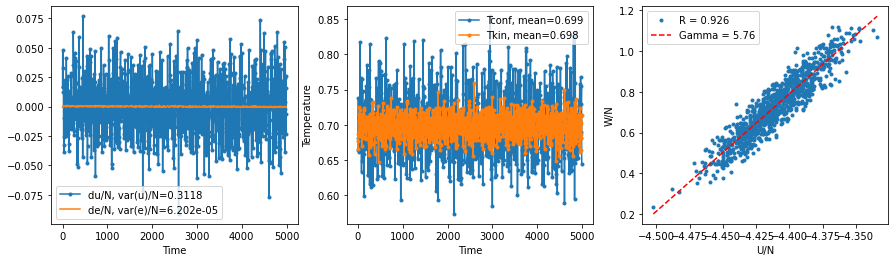

In [6]:
skins, timings, nblist_updates = benchmark(nx=4, ny=4, nz=8, pb=8, tp=32, skin=0.4, UtilizeNIII=False)

Pairpotential paramaters:
 [[(4., -4., 2.5)]]
Generating interactions for 512 particles in 3 dimensions:
	pb: 8, tp:16, num_blocks:64
	Number (virtual) particles: 512
	Number of threads 8192
Generating NVE integrator for 512 particles in 3 dimensions:
	pb: 8, tp:16, num_blocks:64
	Number (virtual) particles: 512
	Number of threads 8192
Generating NVT integrator for 512 particles in 3 dimensions:
	pb: 8, tp:16, num_blocks:64
	Number (virtual) particles: 512
	Number of threads 8192
dt = 0.004999999888241291 = 9.999999776482582 fs
test_steps :  97656


/home/tbs/anaconda3/lib/python3.9/site-packages/numba/cuda/compiler.py:726: NumbaPerformanceWarning: Grid size (64) < 2 * SM count (80) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


0, 0.100, 37860.023, nbflag:[    0     0 27918]
1, 0.200, 71502.854, nbflag:[    0     0 14854]
2, 0.300, 73927.419, nbflag:[    0     0 10047]
3, 0.400, 74621.788, nbflag:[   0    0 7495]
4, 0.500, 74638.908, nbflag:[   0    0 5928]
5, 0.600, 76409.766, nbflag:[   0    0 4816]
6, 0.700, 77875.879, nbflag:[   0    0 4024]
7, 0.800, 72861.728, nbflag:[   0    0 3411]
8, 0.900, 74129.969, nbflag:[   0    0 2915]
9, 1.000, 71109.463, nbflag:[   0    0 2524]
10, 1.100, 72661.902, nbflag:[   0    0 2186]
11, 1.200, 73487.097, nbflag:[   0    0 1915]
12, 1.300, 74984.663, nbflag:[   0    0 1675]
13, 1.400, 69902.150, nbflag:[   0    0 1458]
optimal skin: 0.7
	steps : 1000000
	nbflag :  [    0     0 15015]
	time : 14.0087275390625 s
	time/steps : 14.0087275390625 us
	TPS :  71384.07090947838
	MATS :  36.54864430565293
	ns/day :  61675.83588722693
	ms/year :  22.51168009883783



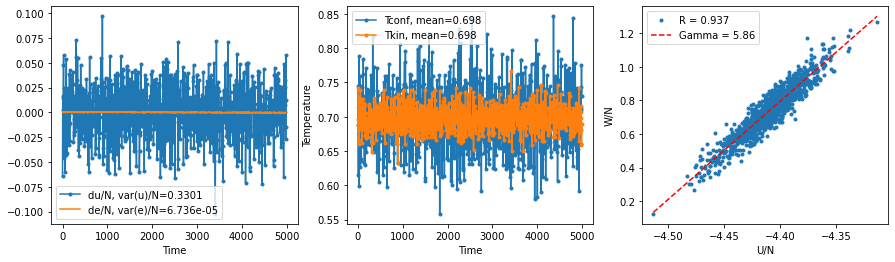

In [4]:
skins, timings, nblist_updates = benchmark(nx=4, ny=4, nz=8, pb=8, tp=16, skin=0.4)

# N=1024

Pairpotential paramaters:
 [[(4., -4., 2.5)]]
Generating interactions for 1024 particles in 3 dimensions:
	pb: 8, tp:16, num_blocks:128
	Number (virtual) particles: 1024
	Number of threads 16384
Generating NVE integrator for 1024 particles in 3 dimensions:
	pb: 8, tp:16, num_blocks:128
	Number (virtual) particles: 1024
	Number of threads 16384
Generating NVT integrator for 1024 particles in 3 dimensions:
	pb: 8, tp:16, num_blocks:128
	Number (virtual) particles: 1024
	Number of threads 16384
dt = 0.004999999888241291 = 9.999999776482582 fs
test_steps :  48828
0, 0.100, 24235.782, nbflag:[    0     0 14934]
1, 0.200, 53695.808, nbflag:[   0    0 7780]
2, 0.300, 56702.131, nbflag:[   0    0 5269]
3, 0.400, 58154.681, nbflag:[   0    0 3939]
4, 0.500, 56723.194, nbflag:[   0    0 3109]
5, 0.600, 56124.855, nbflag:[   0    0 2544]
6, 0.700, 54997.173, nbflag:[   0    0 2130]
7, 0.800, 53288.179, nbflag:[   0    0 1808]
8, 0.900, 51346.290, nbflag:[   0    0 1555]
9, 1.000, 51366.969, nbfla

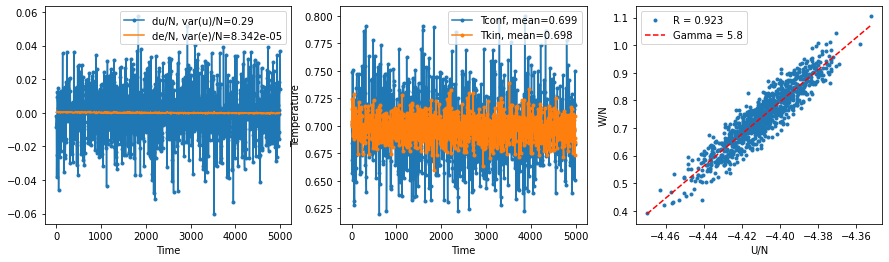

In [8]:
skins, timings, nblist_updates = benchmark(nx=4, ny=8, nz=8, pb=8, tp=16, skin=0.5, UtilizeNIII=False)

Pairpotential paramaters:
 [[(4., -4., 2.5)]]
Generating interactions for 1024 particles in 3 dimensions:
	pb: 8, tp:16, num_blocks:128
	Number (virtual) particles: 1024
	Number of threads 16384
Generating NVE integrator for 1024 particles in 3 dimensions:
	pb: 8, tp:16, num_blocks:128
	Number (virtual) particles: 1024
	Number of threads 16384
Generating NVT integrator for 1024 particles in 3 dimensions:
	pb: 8, tp:16, num_blocks:128
	Number (virtual) particles: 1024
	Number of threads 16384
dt = 0.004999999888241291 = 9.999999776482582 fs
test_steps :  48828
0, 0.100, 22020.298, nbflag:[    0     0 14967]
1, 0.200, 47596.957, nbflag:[   0    0 7764]
2, 0.300, 54548.854, nbflag:[   0    0 5255]
3, 0.400, 49438.033, nbflag:[   0    0 3936]
4, 0.500, 55472.940, nbflag:[   0    0 3103]
5, 0.600, 51139.938, nbflag:[   0    0 2547]
6, 0.700, 47957.049, nbflag:[   0    0 2130]
7, 0.800, 54599.561, nbflag:[   0    0 1808]
8, 0.900, 49265.729, nbflag:[   0    0 1556]
9, 1.000, 46892.368, nbfla

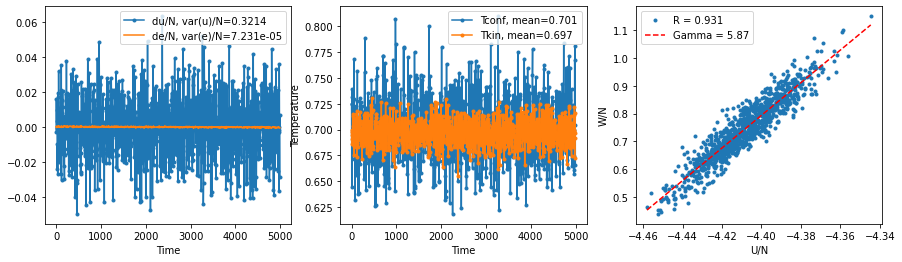

In [5]:
skins, timings, nblist_updates = benchmark(nx=4, ny=8, nz=8, pb=8, tp=16, skin=0.5)

# N=2048

Pairpotential paramaters:
 [[(4., -4., 2.5)]]
Generating interactions for 2048 particles in 3 dimensions:
	pb: 16, tp:8, num_blocks:128
	Number (virtual) particles: 2048
	Number of threads 16384
Generating NVE integrator for 2048 particles in 3 dimensions:
	pb: 16, tp:8, num_blocks:128
	Number (virtual) particles: 2048
	Number of threads 16384
Generating NVT integrator for 2048 particles in 3 dimensions:
	pb: 16, tp:8, num_blocks:128
	Number (virtual) particles: 2048
	Number of threads 16384
dt = 0.004999999888241291 = 9.999999776482582 fs
test_steps :  24414
0, 0.100, 11057.477, nbflag:[   0    0 7936]
1, 0.200, 28033.302, nbflag:[   0    0 4053]
2, 0.300, 32282.467, nbflag:[   0    0 2737]
3, 0.400, 31446.416, nbflag:[   0    0 2045]
4, 0.500, 34558.046, nbflag:[   0    0 1630]
5, 0.600, 35250.201, nbflag:[   0    0 1333]
6, 0.700, 32337.093, nbflag:[   0    0 1122]
7, 0.800, 34830.343, nbflag:[  0   0 956]
8, 0.900, 31766.367, nbflag:[  0   0 829]
9, 1.000, 34421.104, nbflag:[  0   

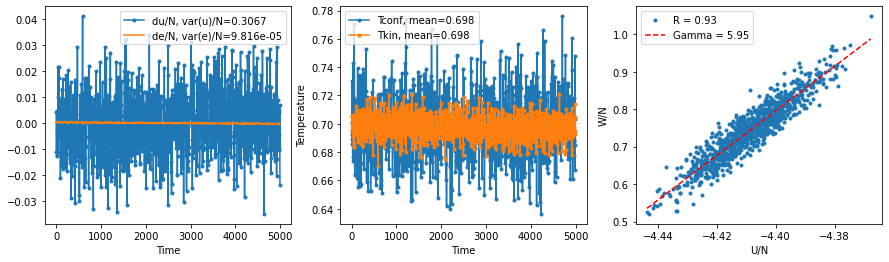

In [6]:
skins, timings, nblist_updates = benchmark(nx=8, ny=8, nz=8, pb=16, tp=8, skin=0.5)

# N=4096

Pairpotential paramaters:
 [[(4., -4., 2.5)]]
Generating interactions for 4096 particles in 3 dimensions:
	pb: 16, tp:4, num_blocks:256
	Number (virtual) particles: 4096
	Number of threads 16384
Generating NVE integrator for 4096 particles in 3 dimensions:
	pb: 16, tp:4, num_blocks:256
	Number (virtual) particles: 4096
	Number of threads 16384
Generating NVT integrator for 4096 particles in 3 dimensions:
	pb: 16, tp:4, num_blocks:256
	Number (virtual) particles: 4096
	Number of threads 16384
dt = 0.004999999888241291 = 9.999999776482582 fs
test_steps :  12207
0, 0.100, 4732.992, nbflag:[   0    0 4062]
1, 0.200, 12603.409, nbflag:[   0    0 2084]
2, 0.300, 15143.304, nbflag:[   0    0 1424]
3, 0.400, 16850.636, nbflag:[   0    0 1070]
4, 0.500, 17774.800, nbflag:[  0   0 847]
5, 0.600, 18357.547, nbflag:[  0   0 695]
6, 0.700, 18335.438, nbflag:[  0   0 585]
7, 0.800, 18618.300, nbflag:[  0   0 502]
8, 0.900, 18324.379, nbflag:[  0   0 435]
9, 1.000, 18069.472, nbflag:[  0   0 380]
10,

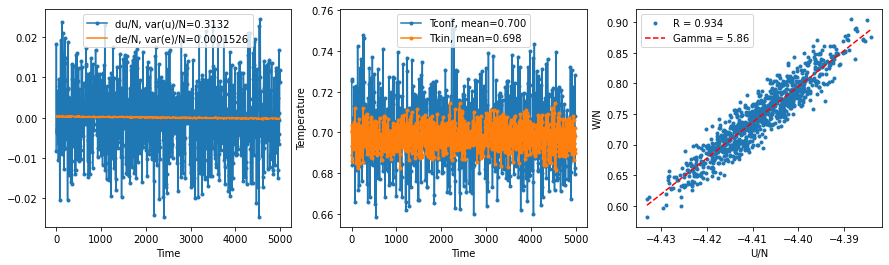

In [7]:
skins, timings, nblist_updates = benchmark(nx=8, ny=8, nz=16, pb=16, tp=4, skin=0.6)

Pairpotential paramaters:
 [[(4., -4., 2.5)]]
Generating interactions for 4096 particles in 3 dimensions:
	pb: 16, tp:4, num_blocks:256
	Number (virtual) particles: 4096
	Number of threads 16384
Generating NVE integrator for 4096 particles in 3 dimensions:
	pb: 16, tp:4, num_blocks:256
	Number (virtual) particles: 4096
	Number of threads 16384
Generating NVT integrator for 4096 particles in 3 dimensions:
	pb: 16, tp:4, num_blocks:256
	Number (virtual) particles: 4096
	Number of threads 16384
dt = 0.004999999888241291 = 9.999999776482582 fs
test_steps :  12207
0, 0.100, 4444.910, nbflag:[   0    0 4055]
1, 0.200, 11746.412, nbflag:[   0    0 2094]
2, 0.300, 13770.207, nbflag:[   0    0 1419]
3, 0.400, 15191.163, nbflag:[   0    0 1065]
4, 0.500, 15851.512, nbflag:[  0   0 845]
5, 0.600, 16420.748, nbflag:[  0   0 696]
6, 0.700, 16442.183, nbflag:[  0   0 585]
7, 0.800, 16575.666, nbflag:[  0   0 503]
8, 0.900, 16485.745, nbflag:[  0   0 437]
9, 1.000, 16144.767, nbflag:[  0   0 383]
10,

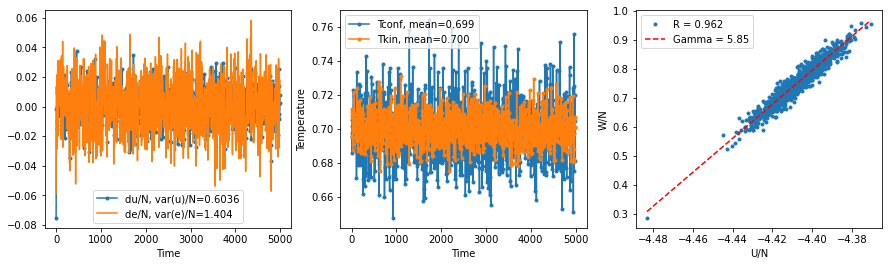

In [8]:
skins, timings, nblist_updates = benchmark(nx=8, ny=8, nz=16, pb=16, tp=4, skin=0.6, integrator='NVT')

# N=8192

Pairpotential paramaters:
 [[(4., -4., 2.5)]]
Generating interactions for 8192 particles in 3 dimensions:
	pb: 32, tp:2, num_blocks:256
	Number (virtual) particles: 8192
	Number of threads 16384
Generating NVE integrator for 8192 particles in 3 dimensions:
	pb: 32, tp:2, num_blocks:256
	Number (virtual) particles: 8192
	Number of threads 16384
Generating NVT integrator for 8192 particles in 3 dimensions:
	pb: 32, tp:2, num_blocks:256
	Number (virtual) particles: 8192
	Number of threads 16384
dt = 0.004999999888241291 = 9.999999776482582 fs
test_steps :  6103
0, 0.100, 1864.066, nbflag:[   0    0 2037]
1, 0.200, 4263.517, nbflag:[   0    0 1075]
2, 0.300, 5498.043, nbflag:[  0   0 737]
3, 0.400, 6373.573, nbflag:[  0   0 556]
4, 0.500, 7086.512, nbflag:[  0   0 440]
5, 0.600, 7443.116, nbflag:[  0   0 362]
6, 0.700, 7650.368, nbflag:[  0   0 308]
7, 0.800, 7750.077, nbflag:[  0   0 263]
8, 0.900, 7744.870, nbflag:[  0   0 228]
9, 1.000, 7640.046, nbflag:[  0   0 201]
10, 1.100, 7567.962

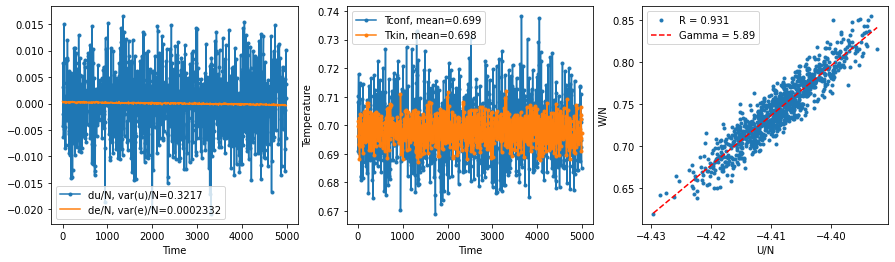

In [9]:
skins, timings, nblist_updates = benchmark(nx=8, ny=16, nz=16, pb=32, tp=2, skin=0.9)

Pairpotential paramaters:
 [[(4., -4., 2.5)]]
Generating interactions for 8192 particles in 3 dimensions:
	pb: 32, tp:2, num_blocks:256
	Number (virtual) particles: 8192
	Number of threads 16384
Generating NVE integrator for 8192 particles in 3 dimensions:
	pb: 32, tp:2, num_blocks:256
	Number (virtual) particles: 8192
	Number of threads 16384
Generating NVT integrator for 8192 particles in 3 dimensions:
	pb: 32, tp:2, num_blocks:256
	Number (virtual) particles: 8192
	Number of threads 16384
dt = 0.004999999888241291 = 9.999999776482582 fs
test_steps :  6103
0, 0.100, 1291.490, nbflag:[   0    0 2037]
1, 0.200, 2999.405, nbflag:[   0    0 1077]
2, 0.300, 3924.119, nbflag:[  0   0 740]
3, 0.400, 4637.036, nbflag:[  0   0 557]
4, 0.500, 5092.533, nbflag:[  0   0 443]
5, 0.600, 5429.546, nbflag:[  0   0 363]
6, 0.700, 5586.851, nbflag:[  0   0 308]
7, 0.800, 5736.126, nbflag:[  0   0 263]
8, 0.900, 5735.926, nbflag:[  0   0 229]
9, 1.000, 5739.458, nbflag:[  0   0 199]
10, 1.100, 5615.807

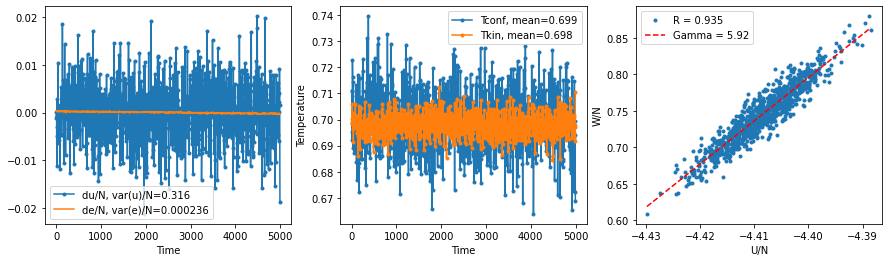

In [14]:
skins, timings, nblist_updates = benchmark(nx=8, ny=16, nz=16, pb=32, tp=2, skin=0.9, UtilizeNIII=False)

Pairpotential paramaters:
 [[(4., -4., 2.5)]]
Generating interactions for 8192 particles in 3 dimensions:
	pb: 64, tp:2, num_blocks:128
	Number (virtual) particles: 8192
	Number of threads 16384
Generating NVE integrator for 8192 particles in 3 dimensions:
	pb: 64, tp:2, num_blocks:128
	Number (virtual) particles: 8192
	Number of threads 16384
Generating NVT integrator for 8192 particles in 3 dimensions:
	pb: 64, tp:2, num_blocks:128
	Number (virtual) particles: 8192
	Number of threads 16384
dt = 0.004999999888241291 = 9.999999776482582 fs
test_steps :  6103
0, 0.100, 1876.131, nbflag:[   0    0 2036]
1, 0.200, 4315.549, nbflag:[   0    0 1072]
2, 0.300, 5494.246, nbflag:[  0   0 740]
3, 0.400, 6443.461, nbflag:[  0   0 554]
4, 0.500, 7087.684, nbflag:[  0   0 440]
5, 0.600, 7469.323, nbflag:[  0   0 361]
6, 0.700, 7702.847, nbflag:[  0   0 305]
7, 0.800, 7821.119, nbflag:[  0   0 261]
8, 0.900, 7821.623, nbflag:[  0   0 228]
9, 1.000, 7854.035, nbflag:[  0   0 201]
10, 1.100, 7716.828

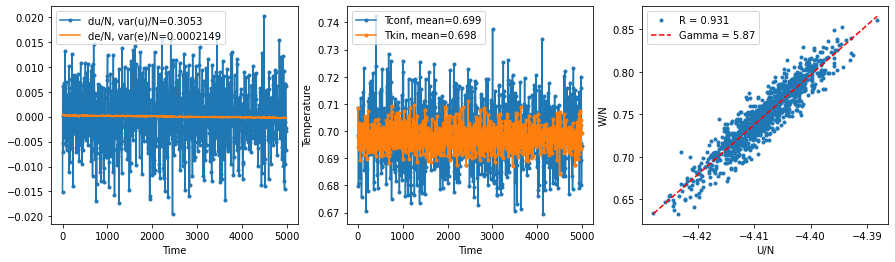

In [10]:
skins, timings, nblist_updates = benchmark(nx=8, ny=16, nz=16, pb=64, tp=2, skin=0.9)

# N=16384

Pairpotential paramaters:
 [[(4., -4., 2.5)]]
Generating interactions for 16384 particles in 3 dimensions:
	pb: 64, tp:1, num_blocks:256
	Number (virtual) particles: 16384
	Number of threads 16384
Generating NVE integrator for 16384 particles in 3 dimensions:
	pb: 64, tp:1, num_blocks:256
	Number (virtual) particles: 16384
	Number of threads 16384
Generating NVT integrator for 16384 particles in 3 dimensions:
	pb: 64, tp:1, num_blocks:256
	Number (virtual) particles: 16384
	Number of threads 16384
dt = 0.004999999888241291 = 9.999999776482582 fs
test_steps :  3051
0, 0.100, 557.813, nbflag:[   0    0 1020]
1, 0.200, 1215.884, nbflag:[  0   0 559]
2, 0.300, 1645.125, nbflag:[  0   0 384]
3, 0.400, 2018.739, nbflag:[  0   0 288]
4, 0.500, 2329.788, nbflag:[  0   0 229]
5, 0.600, 2557.244, nbflag:[  0   0 190]
6, 0.700, 2755.447, nbflag:[  0   0 161]
7, 0.800, 2915.580, nbflag:[  0   0 138]
8, 0.900, 2993.121, nbflag:[  0   0 121]
9, 1.000, 3074.570, nbflag:[  0   0 107]
10, 1.100, 3117.5

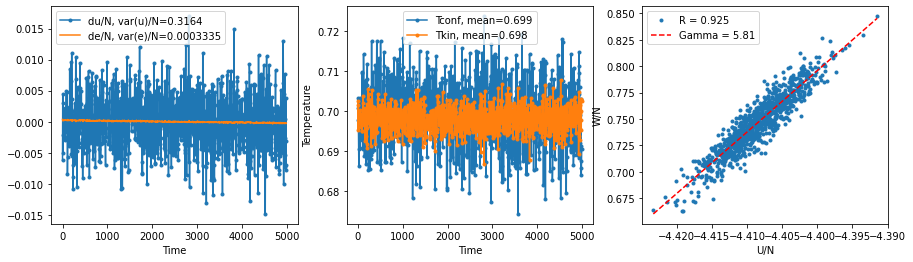

In [11]:
skins, timings, nblist_updates = benchmark(nx=16, ny=16, nz=16, pb=64, tp=1, skin=1.0, gridsync=True, UtilizeNIII=True)

Pairpotential paramaters:
 [[(4., -4., 2.5)]]
Generating interactions for 16384 particles in 3 dimensions:
	pb: 64, tp:1, num_blocks:256
	Number (virtual) particles: 16384
	Number of threads 16384
Generating NVE integrator for 16384 particles in 3 dimensions:
	pb: 64, tp:1, num_blocks:256
	Number (virtual) particles: 16384
	Number of threads 16384
Generating NVT integrator for 16384 particles in 3 dimensions:
	pb: 64, tp:1, num_blocks:256
	Number (virtual) particles: 16384
	Number of threads 16384
dt = 0.004999999888241291 = 9.999999776482582 fs
test_steps :  3051
0, 0.100, 576.385, nbflag:[   0    0 1020]
1, 0.200, 1186.556, nbflag:[  0   0 558]
2, 0.300, 1596.665, nbflag:[  0   0 381]
3, 0.400, 1946.720, nbflag:[  0   0 287]
4, 0.500, 2223.525, nbflag:[  0   0 228]
5, 0.600, 2443.383, nbflag:[  0   0 189]
6, 0.700, 2632.014, nbflag:[  0   0 158]
7, 0.800, 2773.215, nbflag:[  0   0 135]
8, 0.900, 2874.970, nbflag:[  0   0 118]
9, 1.000, 2927.041, nbflag:[  0   0 104]
10, 1.100, 2935.2

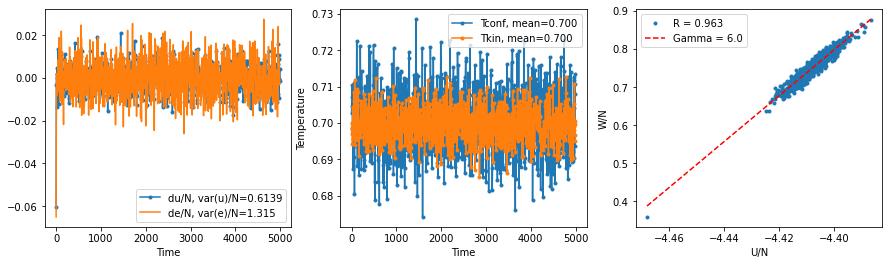

In [12]:
skins, timings, nblist_updates = benchmark(nx=16, ny=16, nz=16, pb=64, tp=1, skin=1.0, gridsync=True, UtilizeNIII=True, integrator='NVT')

Pairpotential paramaters:
 [[(4., -4., 2.5)]]
Generating interactions for 16384 particles in 3 dimensions:
	pb: 64, tp:1, num_blocks:256
	Number (virtual) particles: 16384
	Number of threads 16384
Generating NVE integrator for 16384 particles in 3 dimensions:
	pb: 64, tp:1, num_blocks:256
	Number (virtual) particles: 16384
	Number of threads 16384
Generating NVT integrator for 16384 particles in 3 dimensions:
	pb: 64, tp:1, num_blocks:256
	Number (virtual) particles: 16384
	Number of threads 16384
dt = 0.004999999888241291 = 9.999999776482582 fs
test_steps :  3051
0, 0.100, 408.908, nbflag:[   0    0 1019]
1, 0.200, 807.759, nbflag:[  0   0 552]
2, 0.300, 1110.728, nbflag:[  0   0 379]
3, 0.400, 1377.291, nbflag:[  0   0 286]
4, 0.500, 1608.920, nbflag:[  0   0 228]
5, 0.600, 1790.453, nbflag:[  0   0 188]
6, 0.700, 1937.593, nbflag:[  0   0 159]
7, 0.800, 2051.797, nbflag:[  0   0 137]
8, 0.900, 2135.724, nbflag:[  0   0 120]
9, 1.000, 2204.402, nbflag:[  0   0 105]
10, 1.100, 2222.91

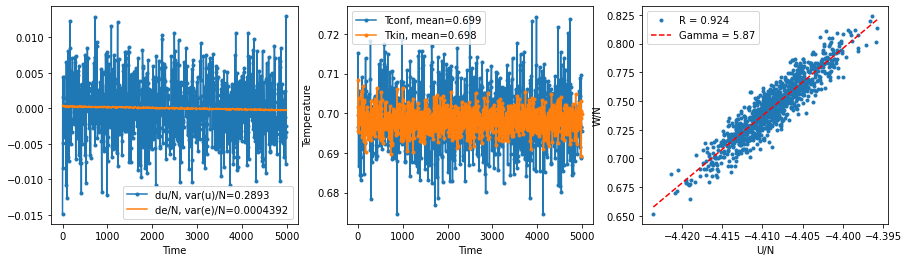

In [18]:
skins, timings, nblist_updates = benchmark(nx=16, ny=16, nz=16, pb=64, tp=1, skin=1.0, gridsync=True, UtilizeNIII=False)

Pairpotential paramaters:
 [[(4., -4., 2.5)]]
Generating interactions for 16384 particles in 3 dimensions:
	pb: 64, tp:2, num_blocks:256
	Number (virtual) particles: 16384
	Number of threads 32768
Generating NVE integrator for 16384 particles in 3 dimensions:
	pb: 64, tp:2, num_blocks:256
	Number (virtual) particles: 16384
	Number of threads 32768
Generating NVT integrator for 16384 particles in 3 dimensions:
	pb: 64, tp:2, num_blocks:256
	Number (virtual) particles: 16384
	Number of threads 32768
dt = 0.004999999888241291 = 9.999999776482582 fs
test_steps :  3051
0, 0.100, 693.996, nbflag:[   0    0 1019]
1, 0.200, 1491.926, nbflag:[  0   0 561]
2, 0.300, 2015.587, nbflag:[  0   0 384]
3, 0.400, 2476.254, nbflag:[  0   0 288]
4, 0.500, 2838.564, nbflag:[  0   0 230]
5, 0.600, 3093.933, nbflag:[  0   0 190]
6, 0.700, 3089.171, nbflag:[  0   0 162]
7, 0.800, 3069.474, nbflag:[  0   0 138]
8, 0.900, 3075.105, nbflag:[  0   0 120]
9, 1.000, 3065.500, nbflag:[  0   0 107]
10, 1.100, 3061.1

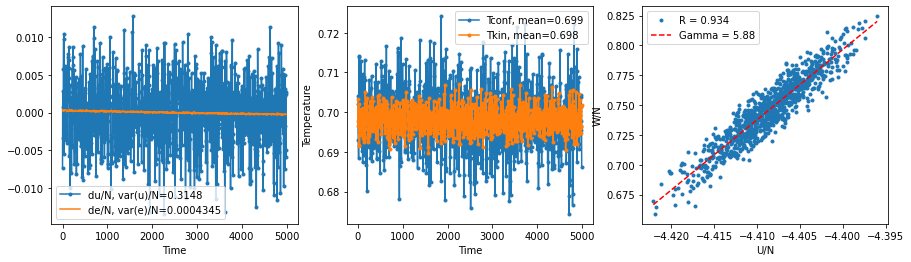

In [13]:
skins, timings, nblist_updates = benchmark(nx=16, ny=16, nz=16, pb=64, tp=2, skin=1.0, gridsync=False, UtilizeNIII=True)

Pairpotential paramaters:
 [[(4., -4., 2.5)]]
Generating interactions for 16384 particles in 3 dimensions:
	pb: 64, tp:2, num_blocks:256
	Number (virtual) particles: 16384
	Number of threads 32768
Generating NVE integrator for 16384 particles in 3 dimensions:
	pb: 64, tp:2, num_blocks:256
	Number (virtual) particles: 16384
	Number of threads 32768
Generating NVT integrator for 16384 particles in 3 dimensions:
	pb: 64, tp:2, num_blocks:256
	Number (virtual) particles: 16384
	Number of threads 32768
dt = 0.004999999888241291 = 9.999999776482582 fs
test_steps :  3051


/home/tbs/anaconda3/lib/python3.9/site-packages/numba/cuda/compiler.py:726: NumbaPerformanceWarning: Grid size (1) < 2 * SM count (80) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/home/tbs/anaconda3/lib/python3.9/site-packages/numba/cuda/compiler.py:726: NumbaPerformanceWarning: Grid size (1) < 2 * SM count (80) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


0, 0.100, 657.038, nbflag:[   0    0 1020]
1, 0.200, 1440.545, nbflag:[  0   0 556]
2, 0.300, 1734.703, nbflag:[  0   0 382]
3, 0.400, 1722.184, nbflag:[  0   0 288]
4, 0.500, 1779.291, nbflag:[  0   0 229]
5, 0.600, 1760.189, nbflag:[  0   0 189]
6, 0.700, 1787.855, nbflag:[  0   0 161]
7, 0.800, 1764.267, nbflag:[  0   0 136]
8, 0.900, 1791.666, nbflag:[  0   0 119]
9, 1.000, 1682.255, nbflag:[  0   0 105]
10, 1.100, 1684.524, nbflag:[ 0  0 93]
11, 1.200, 1765.320, nbflag:[ 0  0 82]
12, 1.300, 1764.874, nbflag:[ 0  0 75]
13, 1.400, 1770.936, nbflag:[ 0  0 68]
optimal skin: 0.8999999999999999
	steps : 1000000
	nbflag :  [    0     0 21844]
	time : 567.0391875 s
	time/steps : 567.0391875 us
	TPS :  1763.5465450084082
	MATS :  28.89394659341776
	ns/day :  1523.7041808298213
	ms/year :  0.5561520260028847



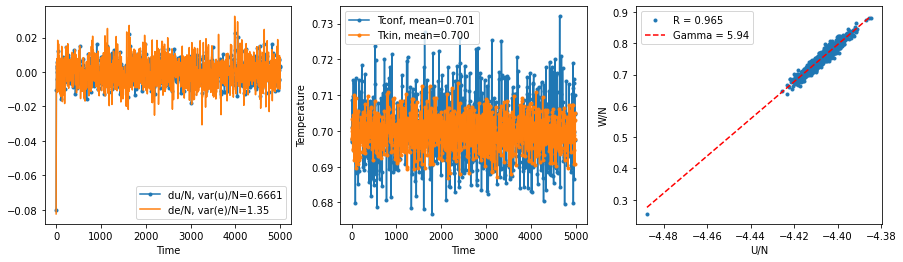

In [14]:
skins, timings, nblist_updates = benchmark(nx=16, ny=16, nz=16, pb=64, tp=2, skin=1.0, gridsync=False, UtilizeNIII=True, integrator='NVT')

Pairpotential paramaters:
 [[(4., -4., 2.5)]]
Generating interactions for 16384 particles in 3 dimensions:
	pb: 64, tp:2, num_blocks:256
	Number (virtual) particles: 16384
	Number of threads 32768
Generating NVE integrator for 16384 particles in 3 dimensions:
	pb: 64, tp:2, num_blocks:256
	Number (virtual) particles: 16384
	Number of threads 32768
Generating NVT integrator for 16384 particles in 3 dimensions:
	pb: 64, tp:2, num_blocks:256
	Number (virtual) particles: 16384
	Number of threads 32768
dt = 0.004999999888241291 = 9.999999776482582 fs
test_steps :  3051
0, 0.100, 540.459, nbflag:[   0    0 1021]
1, 0.200, 1111.247, nbflag:[  0   0 561]
2, 0.300, 1518.887, nbflag:[  0   0 384]
3, 0.400, 1882.421, nbflag:[  0   0 288]
4, 0.500, 2194.622, nbflag:[  0   0 230]
5, 0.600, 2453.748, nbflag:[  0   0 190]
6, 0.700, 2690.622, nbflag:[  0   0 159]
7, 0.800, 2848.354, nbflag:[  0   0 139]
8, 0.900, 2965.341, nbflag:[  0   0 120]
9, 1.000, 2967.293, nbflag:[  0   0 106]
10, 1.100, 2971.6

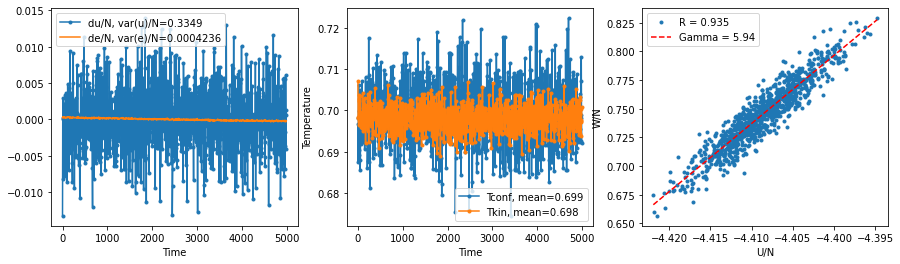

In [21]:
skins, timings, nblist_updates = benchmark(nx=16, ny=16, nz=16, pb=64, tp=2, skin=1.0, gridsync=False, UtilizeNIII=False)

# N=32768

Pairpotential paramaters:
 [[(4., -4., 2.5)]]
Generating interactions for 32768 particles in 3 dimensions:
	pb: 128, tp:1, num_blocks:256
	Number (virtual) particles: 32768
	Number of threads 32768
Generating NVE integrator for 32768 particles in 3 dimensions:
	pb: 128, tp:1, num_blocks:256
	Number (virtual) particles: 32768
	Number of threads 32768
Generating NVT integrator for 32768 particles in 3 dimensions:
	pb: 128, tp:1, num_blocks:256
	Number (virtual) particles: 32768
	Number of threads 32768
dt = 0.004999999888241291 = 9.999999776482582 fs
test_steps :  1525
0, 0.100, 190.091, nbflag:[  0   0 517]
1, 0.200, 391.303, nbflag:[  0   0 296]
2, 0.300, 558.512, nbflag:[  0   0 198]
3, 0.400, 697.448, nbflag:[  0   0 151]
4, 0.500, 835.952, nbflag:[  0   0 119]
5, 0.600, 945.867, nbflag:[ 0  0 99]
6, 0.700, 1054.352, nbflag:[ 0  0 83]
7, 0.800, 1137.986, nbflag:[ 0  0 72]
8, 0.900, 1220.130, nbflag:[ 0  0 63]
9, 1.000, 1260.219, nbflag:[ 0  0 56]
10, 1.100, 1309.648, nbflag:[ 0  0 50

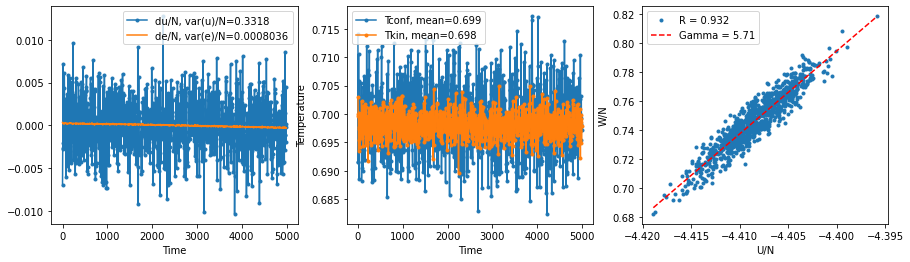

In [15]:
skins, timings, nblist_updates = benchmark(nx=16, ny=16, nz=32, pb=128, tp=1, skin=1.0, gridsync=False)

Pairpotential paramaters:
 [[(4., -4., 2.5)]]
Generating interactions for 32768 particles in 3 dimensions:
	pb: 128, tp:1, num_blocks:256
	Number (virtual) particles: 32768
	Number of threads 32768
Generating NVE integrator for 32768 particles in 3 dimensions:
	pb: 128, tp:1, num_blocks:256
	Number (virtual) particles: 32768
	Number of threads 32768
Generating NVT integrator for 32768 particles in 3 dimensions:
	pb: 128, tp:1, num_blocks:256
	Number (virtual) particles: 32768
	Number of threads 32768
dt = 0.004999999888241291 = 9.999999776482582 fs
test_steps :  1525


/home/tbs/anaconda3/lib/python3.9/site-packages/numba/cuda/compiler.py:726: NumbaPerformanceWarning: Grid size (1) < 2 * SM count (80) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/home/tbs/anaconda3/lib/python3.9/site-packages/numba/cuda/compiler.py:726: NumbaPerformanceWarning: Grid size (1) < 2 * SM count (80) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


0, 0.100, 199.172, nbflag:[  0   0 512]
1, 0.200, 386.172, nbflag:[  0   0 293]
2, 0.300, 545.927, nbflag:[  0   0 196]
3, 0.400, 680.746, nbflag:[  0   0 149]
4, 0.500, 800.042, nbflag:[  0   0 119]
5, 0.600, 913.638, nbflag:[ 0  0 98]
6, 0.700, 1004.142, nbflag:[ 0  0 83]
7, 0.800, 1078.886, nbflag:[ 0  0 72]
8, 0.900, 1159.007, nbflag:[ 0  0 62]
9, 1.000, 1197.338, nbflag:[ 0  0 56]
10, 1.100, 1250.144, nbflag:[ 0  0 49]
11, 1.200, 1286.219, nbflag:[ 0  0 43]
12, 1.300, 1298.946, nbflag:[ 0  0 39]
13, 1.400, 1289.039, nbflag:[ 0  0 36]
optimal skin: 1.3
	steps : 1000000
	nbflag :  [    0     0 22971]
	time : 990.0479375 s
	time/steps : 990.0479375 us
	TPS :  1010.0521016438155
	MATS :  33.09738726666455
	ns/day :  872.6849963142265
	ms/year :  0.3185300236546927



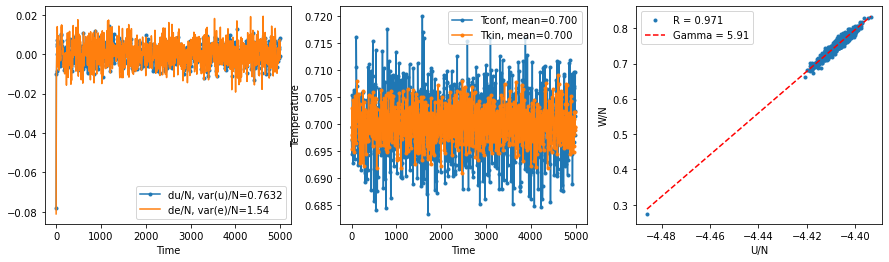

In [16]:
skins, timings, nblist_updates = benchmark(nx=16, ny=16, nz=32, pb=128, tp=1, skin=1.0, gridsync=False, UtilizeNIII=True, integrator='NVT')

# Benchmarks

In [24]:

Ns = np.array([512, 1024, 2048, 4096, 8192, 16384, 32768])
TPS_rumd_1080 = np.array([35354, 34226, 31454, 17508, 8824, 6617, 3075])
TPS_rumdpy_3070lap_11 = np.array([80549, 63196, 37959, 17010, 6495, 3441, 872])
TPS_rumdpy_3070lap_12 = np.array([72585, 57683, 37063, 20163, 9180, 3341, 1174])
TPS_rumdpy_3070lap_15 = np.array([80607, 63118, 36931, 20413, 9365, 3365, 1179])
TPS_rumdpy_3070lap_19 = np.array([80789, 63171, 37593, 21635, 9431, 3241, 1165])
TPS_rumdpy_3070lap_25 = np.array([82198, 58611, 34459, 19226, 8300, 3387, 1086])
TPS_rumdpy_3070lap_27 = np.array([81754, 58291, 34427, 18839, 8208, 3462, 1103])
TPS_rumdpy_3070lap_28 = np.array([82215, 60171, 35793, 18839, 8208, 3462, 1103])


print(f'Speed-up: {(TPS_rumdpy_3070lap_27/TPS_rumdpy_3070lap_11)}')

Speed-up: [1.01495984 0.92238433 0.90695224 1.10752499 1.26374134 1.00610288
 1.26490826]


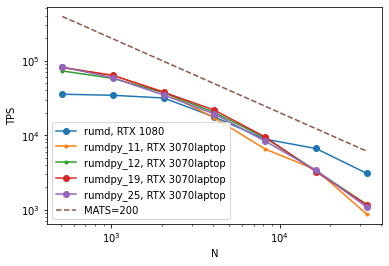

In [25]:
### plt.figure(figsize=(12,8))
plt.loglog(Ns, TPS_rumd_1080, 'o-', label='rumd, RTX 1080')
plt.loglog(Ns, TPS_rumdpy_3070lap_11, '.-', label='rumdpy_11, RTX 3070laptop')
plt.loglog(Ns, TPS_rumdpy_3070lap_12, '.-', label='rumdpy_12, RTX 3070laptop')
plt.loglog(Ns, TPS_rumdpy_3070lap_19, 'o-', label='rumdpy_19, RTX 3070laptop')
plt.loglog(Ns, TPS_rumdpy_3070lap_25, 'o-', label='rumdpy_25, RTX 3070laptop')
plt.loglog(Ns, 200*1e6/Ns, '--', label='MATS=200')
plt.legend()
plt.xlabel('N')
plt.ylabel('TPS')
plt.show()